In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPool2D, BatchNormalization
from keras.optimizers import RMSprop
import seaborn as sns
%matplotlib inline

import matplotlib.pyplot as plt


Using TensorFlow backend.


# 1.Data Preparation 

## 1.1 Load Data

In [3]:

test_file='/kaggle/input/digit-recognizer/test.csv'
train_file='/kaggle/input/digit-recognizer/train.csv'
sub_file='/kaggle/input/digit-recognizer/sample_submission.csv'

In [4]:
sub=pd.read_csv(sub_file)
train =pd.read_csv(train_file)
test=pd.read_csv(test_file)

In [5]:
train.head()


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test.head()


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
print('Shape of train data ',train.shape)
print('Shape of test data',test.shape)

Shape of train data  (42000, 785)
Shape of test data (28000, 784)


## 1.2 Check for missing values

In [8]:
train.columns[train.isnull().any()]

Index([], dtype='object')

In [9]:
test.columns[test.isnull().any()]

Index([], dtype='object')

There is no missing values in the train and test dataset. So we can safely go ahead.

In [10]:
## 1.3 Count for each Class

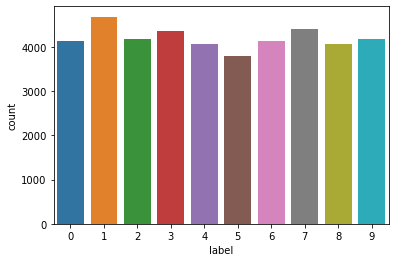

In [11]:
# Print data histogram
g = sns.countplot(train.label)

We have similar counts for the 10 digits.No imbalanced Class

## 1.3 Target label and Reshape training and test data

In [12]:
img_rows=28
img_cols=28
num_classes=10

def prep_data(data):
    num_images=data.shape[0]
    
    out_y = keras.utils.to_categorical(data.label, 10)  # Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
    
    x = data.drop(['label'],axis=1)   
    
    x_train = np.array(x)   #first we have to convert into array so to use .reshape function
    out_x=x_train.reshape(-1, img_rows, img_cols, 1)   #Reshaping it into tensor
    
    #we can directly use like this without converting it into arrays
    #out_x = x.values.reshape(-1, img_rows, img_cols, 1) 
    
    out_x = out_x / 255   #Normalisation
    return out_x, out_y


In [13]:
def test_prep_data(data):
    x_test = np.array(data)

    out_x=x_test.reshape(-1, img_rows, img_cols, 1)   #Reshaping it into tensor
    #out_x = data.values.reshape(-1, img_rows, img_cols, 1)
    out_x = out_x / 255
    return out_x

In [14]:
x_train,y_train=prep_data(train)

In [15]:
x_test=test_prep_data(test)

In [16]:
## 1.4 Plot Sample images 

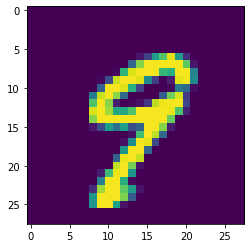

In [17]:

#Test print a digit
h = plt.imshow(x_train[11][:,:,0])

## Function to predict & label the final predicted values

In [18]:
def predict_model(model,test):
    y_test=model.predict(test)
    y_max = np.argmax(y_test,axis = 1)
    sub['Label'] = y_max
    return sub
    

* # First Convolutional basic model(val accuracy = 0.9832 )

In [19]:
# def cnn_model_a():
#     model = Sequential()
#     model.add(Conv2D(20, kernel_size=(3, 3),
#                  activation='relu',
#                  input_shape=(img_rows, img_cols, 1)))
#     model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
#     model.add(Conv2D(20, kernel_size=(3, 3), activation='relu'))
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
#     model.add(Dense(num_classes, activation='softmax'))

#     model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer='adam',
#               metrics=['accuracy'])
#     return model
# model_a=cnn_model_a()

In [20]:
# model_a.fit(x_train, y_train,
#           batch_size=128,
#           epochs=3,
#           validation_split = 0.2)

## Second model with deep layer(accuracy test=0.9935)

In [21]:
def cnn_model_b():
    model = Sequential()
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
  #  model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))
    
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
#     model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.20))
    
    
  
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                     activation ='relu'))
   # model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.20))
    
    model.add(Flatten())
    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(0.20))
    model.add(Dense(128, activation = "relu"))
    model.add(Dropout(0.20))
    model.add(Dense(10, activation = "softmax"))
    # optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
    model.compile( optimizer='adam' , loss = keras.losses.categorical_crossentropy, metrics=["accuracy"])
    return model
model_b=cnn_model_b()
model_b.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

# print out model look
from keras.utils import plot_model
plot_model(model_b, to_file='model_b.png', show_shapes=True, show_layer_names=True)
from IPython.display import Image
Image("model_b.png")

In [22]:
model_b=cnn_model_b()
model_b.fit(x_train, y_train,
          batch_size=200,
          epochs=30,
          validation_split = 0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/30
33600/33600 [==============================] - 7s 206us/sample - loss: 0.4871 - accuracy: 0.8363 - val_loss: 0.0723 - val_accuracy: 0.9773
Epoch 2/30
33600/33600 [==============================] - 3s 78us/sample - loss: 0.0951 - accuracy: 0.9717 - val_loss: 0.0550 - val_accuracy: 0.9825
Epoch 3/30
33600/33600 [==============================] - 3s 78us/sample - loss: 0.0651 - accuracy: 0.9800 - val_loss: 0.0480 - val_accuracy: 0.9850
Epoch 4/30
33600/33600 [==============================] - 3s 81us/sample - loss: 0.0552 - accuracy: 0.9831 - val_loss: 0.0352 - val_accuracy: 0.9888
Epoch 5/30
33600/33600 [==============================] - 3s 78us/sample - loss: 0.0420 - accuracy: 0.9880 - val_loss: 0.0307 - val_accuracy: 0.9910
Epoch 6/30
33600/33600 [==============================] - 3s 79us/sample - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0351 - val_accuracy: 0.9902
Epoch 7/30
33600/33600 [==============================] 

# Third model with deep layer(accuracy test=.9939)

In [23]:
 # Set the CNN model 
 # my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out

def cnn_model_c():
    model = Sequential()

    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))


    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1)))
    model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
    model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
    model.add(Dropout(0.25))



    model.add(Flatten())
    model.add(Dense(256, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = "softmax"))
    model.compile( optimizer='adam' , loss = keras.losses.categorical_crossentropy, metrics=["accuracy"])
    return model
model_c=cnn_model_c()
model_c.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 14, 14, 32)        25632     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)         

In [24]:
model_c=cnn_model_c()
model_c.fit(x_train, y_train,
          batch_size=200,
          epochs=50,
          validation_split = 0.2)

Train on 33600 samples, validate on 8400 samples
Epoch 1/50
33600/33600 [==============================] - 3s 103us/sample - loss: 1.0091 - accuracy: 0.6508 - val_loss: 0.1462 - val_accuracy: 0.9569
Epoch 2/50
33600/33600 [==============================] - 2s 74us/sample - loss: 0.1756 - accuracy: 0.9528 - val_loss: 0.1262 - val_accuracy: 0.9646
Epoch 3/50
33600/33600 [==============================] - 2s 69us/sample - loss: 0.1142 - accuracy: 0.9701 - val_loss: 0.0612 - val_accuracy: 0.9825
Epoch 4/50
33600/33600 [==============================] - 2s 68us/sample - loss: 0.0881 - accuracy: 0.9769 - val_loss: 0.0613 - val_accuracy: 0.9837
Epoch 5/50
33600/33600 [==============================] - 2s 66us/sample - loss: 0.0682 - accuracy: 0.9815 - val_loss: 0.0590 - val_accuracy: 0.9852
Epoch 6/50
33600/33600 [==============================] - 2s 66us/sample - loss: 0.0585 - accuracy: 0.9854 - val_loss: 0.0433 - val_accuracy: 0.9888
Epoch 7/50
33600/33600 [==============================] 

# Data augmentation to prevent overfitting 

In [25]:
from keras.callbacks import ReduceLROnPlateau

#Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, #number of epochs with no improvement after which learning rate will be reduced.
                                            verbose=1, #Display a message after each epoch
                                            factor=0.5, 
                                            min_lr=0.00001)

In [26]:
#Split data first into training and validation dataset
from sklearn.model_selection import train_test_split
random_seed = 2


train_x, val_x, train_y, val_y = train_test_split(x_train, y_train, test_size = 0.1, random_state=random_seed)

In [27]:
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images



### Data augmentation on model_b (val_accuracy 0.9948)

In [28]:
epochs = 40
batch_size = 50

aug_model_b=cnn_model_b()
# Fit the model
aug_model_b.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_x,val_y),
                              verbose = 2, steps_per_epoch=train_x.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Train for 756 steps, validate on 4200 samples
Epoch 1/40
756/756 - 16s - loss: 0.3711 - accuracy: 0.8784 - val_loss: 0.0671 - val_accuracy: 0.9814
Epoch 2/40
756/756 - 14s - loss: 0.1121 - accuracy: 0.9675 - val_loss: 0.0376 - val_accuracy: 0.9883
Epoch 3/40
756/756 - 14s - loss: 0.0837 - accuracy: 0.9760 - val_loss: 0.0318 - val_accuracy: 0.9900
Epoch 4/40
756/756 - 14s - loss: 0.0720 - accuracy: 0.9792 - val_loss: 0.0342 - val_accuracy: 0.9910
Epoch 5/40
756/756 - 15s - loss: 0.0630 - accuracy: 0.9813 - val_loss: 0.0288 - val_accuracy: 0.9921
Epoch 6/40
756/756 - 14s - loss: 0.0585 - accuracy: 0.9830 - val_loss: 0.0283 - val_accuracy: 0.9912
Epoch 7/40
756/756 - 13s - loss: 0.0555 - accuracy: 0.9847 - val_loss: 0.0203 - val_accuracy: 0.9945
Epoch 8/40
756/756 - 14s - loss: 0.0494 - accuracy: 0.9857 - val_loss: 0.0251 - val_accuracy: 0.9921
Epoch 9/40
756/756 - 14s - loss: 0.0502 - accuracy: 0.9861 - val_loss: 0.0296 - val_accuracy: 0.9926
Epoch 10/40

Epoch 00010: ReduceLROnPlateau r

Here We can see that val_accuracy increased on model_b by applying data augmentation. Data augmentation largely reduces Overfitting.

In [29]:
sub_aug_b=predict_model(aug_model_b,x_test)
sub_aug_b.to_csv('submission_aug_b.csv', index=False)

### Data augmentation on model_c(val_accuracy=.9960)

In [30]:
epochs = 40
batch_size = 86

aug_model_c=cnn_model_c()
# Fit the model
aug_model_c.fit_generator(datagen.flow(train_x,train_y, batch_size=batch_size),
                              epochs = epochs, validation_data = (val_x,val_y),
                              verbose = 2, steps_per_epoch=train_x.shape[0] // batch_size,
                              callbacks=[learning_rate_reduction])

Train for 439 steps, validate on 4200 samples
Epoch 1/40
439/439 - 13s - loss: 0.7290 - accuracy: 0.7535 - val_loss: 0.1363 - val_accuracy: 0.9576
Epoch 2/40
439/439 - 12s - loss: 0.1613 - accuracy: 0.9581 - val_loss: 0.0738 - val_accuracy: 0.9826
Epoch 3/40
439/439 - 12s - loss: 0.1146 - accuracy: 0.9701 - val_loss: 0.0484 - val_accuracy: 0.9869
Epoch 4/40
439/439 - 13s - loss: 0.0998 - accuracy: 0.9756 - val_loss: 0.0515 - val_accuracy: 0.9864
Epoch 5/40
439/439 - 13s - loss: 0.0860 - accuracy: 0.9781 - val_loss: 0.0330 - val_accuracy: 0.9898
Epoch 6/40
439/439 - 12s - loss: 0.0854 - accuracy: 0.9783 - val_loss: 0.0326 - val_accuracy: 0.9900
Epoch 7/40
439/439 - 12s - loss: 0.0701 - accuracy: 0.9827 - val_loss: 0.0417 - val_accuracy: 0.9893
Epoch 8/40
439/439 - 13s - loss: 0.0683 - accuracy: 0.9828 - val_loss: 0.0442 - val_accuracy: 0.9910
Epoch 9/40
439/439 - 13s - loss: 0.0640 - accuracy: 0.9840 - val_loss: 0.0266 - val_accuracy: 0.9936
Epoch 10/40
439/439 - 12s - loss: 0.0569 - ac

In [31]:
sub_aug_c=predict_model(aug_model_c,x_test)
sub_aug_c.to_csv('submission_aug_c.csv', index=False)